In [74]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch import nn
import copy
import csp_densenet
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import pandas as pd
import random
import covid_classification

In [75]:
import seaborn as sn
def confusion_matrix_figure(val_result, test_result, num_classes, model):
    if num_classes==3:
        sub = 'multi'
        cols = ['covid-19', 'normal', 'pnuemonia']
    elif num_classes==2:
        sub = 'binary'
        cols = ['covid-19', 'non-covid']
    fig = plt.figure(figsize=(5,5))
    val_df = pd.DataFrame(val_result['confusion_matrix'], columns=cols, index=cols)
    sn.heatmap(val_df, annot=True)
#     plt.yticks(rotation=0) 
    fig.savefig('figures/'+sub+'/'+model+'_val.png', format='png', dpi=300)
    fig = plt.figure(figsize=(5,5))
    test_df = pd.DataFrame(test_result['confusion_matrix'], columns=cols, index=cols)
    sn.heatmap(test_df, annot=True)
#     plt.yticks(rotation=0) 
    fig.savefig('figures/'+sub+'/'+model+'_test'+'.png', format='png', dpi=300)

In [76]:
from torchvision.utils import make_grid
from PIL import Image
def show(tensors_list, title, figsize=(10,10), nrow=2, num_classes=3):
    if len(tensors_list)<3:
        figsize=(figsize[0],figsize[1]/2)
    if num_classes==3:
        sub = 'multi'
    elif num_classes==2:
        sub = 'binary'
    grid_img = make_grid(tensor=tensors_list,  nrow=nrow)
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    fig.savefig('figures/'+sub+'/'+title+'_test'+'.png', format='png', dpi=300)
def image_to_tensor(image_paths):
    trans1 = transforms.ToTensor()
    li_tensors = [trans1(Image.open(im)) for im in image_paths]
    # li_ = [trans1(Image.open(im).convert("RGB")) for im in li]
    return li_tensors
def grid_images(test_result, typ='incorrect_identified'):
    covid_identified_as_other = {}
    incorrectly_identified_as_covid = {}
    for input_ in test_result[typ]:
        true_label, predicted_label, tensor_, image_path = input_
        true_label = true_label.tolist()
        predicted_label = predicted_label.tolist()
        if true_label==0:
            covid_identified_as_other[image_path] = (true_label, predicted_label)
        if true_label!=0:
            incorrectly_identified_as_covid[image_path] = (true_label, predicted_label)
    return covid_identified_as_other, incorrectly_identified_as_covid


In [7]:
import datadownload
# datadownload.dataset_download()

In [8]:
import remove_weights
# remove_weights.remove()

In [9]:
import datapreparation
# datapreparation.dataprepare()

In [77]:
def seed_torch(seed=100):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



In [78]:
seed = 200
seed_torch(seed)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
classification = 'multi'
if classification=='binary':
    num_classes = 2
elif classification=='multi':
    num_classes = 3
else:
    raise Exception("invalid classification")
    
train_dataset_path = os.path.join(os.getcwd(), 'dataset', classification, 'train')
val_dataset_path = os.path.join(os.getcwd(), 'dataset', classification, 'val')
test_dataset_path = os.path.join(os.getcwd(), 'dataset', classification, 'test')

In [79]:
epochs = 100
batch_size = 16

step=''
criterion = nn.CrossEntropyLoss()#categorical_crossentropy, 

timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
final_result={}
timestamp
#lr 

'20210427165655'

In [7]:
for csp_variant in [csp_densenet.csp_densenet121, csp_densenet.csp_densenet169, csp_densenet.csp_densenet201]:
    print(csp_variant, 'Begin')
    model = csp_variant(num_classes=num_classes)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8, weight_decay = 0.005)#
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=1, min_lr=0, eps=1e-15)#step mandatory
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=500)
    train_result = covid_classification.training(train_dataset_path, val_dataset_path, batch_size, epochs, classification, model, device, optimizer, scheduler, criterion, seed, step )
    model_path = train_result['best_model_path']#'/mnt/disks/user/project/weights/binary/20210327172502/0.pt'
    test_result = covid_classification.testing(test_dataset_path, batch_size, model_path, device, criterion, num_classes)
    final_result[str(csp_variant).split(' ')[1]+timestamp] = {'train_result':train_result, 'test_result':test_result}
    print(csp_variant, 'End')

<function csp_densenet121 at 0x7f572da91378> Begin
/mnt/disks/user/project/weights/multi/20210425183736 model_save_path
EPOCH: 0 started at: 2021-04-25 18:37:36.473926
Finished Training with an accuracy of  49.22077922077922 %
avg loss 0.9809050277336356
Accuracy of the network on the test images: 66 %
avg loss 0.6819066524505615
0.0011979999999999782 lr
EPOCH: 1 started at: 2021-04-25 18:39:08.171795
Finished Training with an accuracy of  69.22077922077922 %
avg loss 0.7367096819828466
Accuracy of the network on the test images: 83 %
avg loss 0.5519740343093872
0.0013960000000000003 lr
EPOCH: 2 started at: 2021-04-25 18:40:30.601265
Finished Training with an accuracy of  77.33766233766234 %
avg loss 0.5855079591274261
Accuracy of the network on the test images: 84 %
avg loss 0.3921557113528252
0.0015939999999999787 lr
EPOCH: 3 started at: 2021-04-25 18:41:52.950098
Finished Training with an accuracy of  85.45454545454545 %
avg loss 0.41570411069491475
Accuracy of the network on the te

Finished Training with an accuracy of  99.0909090909091 %
avg loss 0.05724102847119697
Accuracy of the network on the test images: 98 %
avg loss 0.08766652720514685
0.007929999999999986 lr
EPOCH: 35 started at: 2021-04-25 19:25:39.990872
Finished Training with an accuracy of  97.01298701298701 %
avg loss 0.0967228882802055
Accuracy of the network on the test images: 98 %
avg loss 0.11441431362181902
0.008128000000000007 lr
EPOCH: 36 started at: 2021-04-25 19:27:01.520897
Finished Training with an accuracy of  97.85714285714285 %
avg loss 0.061067999191774226
Accuracy of the network on the test images: 93 %
avg loss 0.2734572239220142
0.008325999999999986 lr
EPOCH: 37 started at: 2021-04-25 19:28:22.987067
Finished Training with an accuracy of  99.0909090909091 %
avg loss 0.04088423119560268
Accuracy of the network on the test images: 93 %
avg loss 0.17125204205513
0.008524000000000007 lr
EPOCH: 38 started at: 2021-04-25 19:29:48.956481
Finished Training with an accuracy of  99.35064935

Finished Training with an accuracy of  97.20779220779221 %
avg loss 0.09448964045066194
Accuracy of the network on the test images: 95 %
avg loss 0.13735002386383713
0.014860000000000012 lr
EPOCH: 70 started at: 2021-04-25 20:13:44.976527
Finished Training with an accuracy of  98.11688311688312 %
avg loss 0.05943244956817824
Accuracy of the network on the test images: 90 %
avg loss 0.26884331507608294
0.015057999999999992 lr
EPOCH: 71 started at: 2021-04-25 20:15:09.345204
Finished Training with an accuracy of  99.28571428571429 %
avg loss 0.03505667878228441
Accuracy of the network on the test images: 93 %
avg loss 0.15038352385163306
0.015256000000000013 lr
EPOCH: 72 started at: 2021-04-25 20:16:30.844649
Finished Training with an accuracy of  97.53246753246754 %
avg loss 0.07968393809728555
Accuracy of the network on the test images: 64 %
avg loss 1.064006696510478
0.015453999999999992 lr
EPOCH: 73 started at: 2021-04-25 20:17:52.638250
Finished Training with an accuracy of  95.9090

Accuracy of the network on the test images: 89 %
avg loss 0.3812179934233427
0.0015939999999999787 lr
EPOCH: 3 started at: 2021-04-25 21:00:16.838252
Finished Training with an accuracy of  84.54545454545455 %
avg loss 0.4256125502672392
Accuracy of the network on the test images: 89 %
avg loss 0.5478595912456512
0.0017920000000000006 lr
EPOCH: 4 started at: 2021-04-25 21:01:58.267284
Finished Training with an accuracy of  88.18181818181819 %
avg loss 0.3173955497667961
Accuracy of the network on the test images: 86 %
avg loss 0.6870985984802246
0.0019899999999999788 lr
EPOCH: 5 started at: 2021-04-25 21:03:41.184678
Finished Training with an accuracy of  93.24675324675324 %
avg loss 0.2026400568021327
Accuracy of the network on the test images: 92 %
avg loss 0.2303110659122467
0.002188000000000001 lr
EPOCH: 6 started at: 2021-04-25 21:05:21.675542
Finished Training with an accuracy of  93.5064935064935 %
avg loss 0.18475558697101996
Accuracy of the network on the test images: 90 %
avg 

Finished Training with an accuracy of  99.61038961038962 %
avg loss 0.019462623976689485
Accuracy of the network on the test images: 95 %
avg loss 0.10791021666955203
0.008524000000000007 lr
EPOCH: 38 started at: 2021-04-25 21:59:25.509008
Finished Training with an accuracy of  99.87012987012987 %
avg loss 0.01584718660955538
Accuracy of the network on the test images: 95 %
avg loss 0.19885149523615836
0.008721999999999985 lr
EPOCH: 39 started at: 2021-04-25 22:01:06.811910
Finished Training with an accuracy of  98.76623376623377 %
avg loss 0.03765539101147352
Accuracy of the network on the test images: 95 %
avg loss 0.15386828184127807
0.008920000000000008 lr
EPOCH: 40 started at: 2021-04-25 22:02:47.762565
Finished Training with an accuracy of  98.8961038961039 %
avg loss 0.04241996375632655
Accuracy of the network on the test images: 86 %
avg loss 0.354077044967562
0.009117999999999987 lr
EPOCH: 41 started at: 2021-04-25 22:04:28.424293
Finished Training with an accuracy of  97.2077

Finished Training with an accuracy of  97.92207792207792 %
avg loss 0.06289391987717029
Accuracy of the network on the test images: 93 %
avg loss 0.2304304813966155
0.015453999999999992 lr
EPOCH: 73 started at: 2021-04-25 22:58:42.716060
Finished Training with an accuracy of  98.18181818181819 %
avg loss 0.060636442807531846
Accuracy of the network on the test images: 92 %
avg loss 0.1584648359566927
0.015652000000000013 lr
EPOCH: 74 started at: 2021-04-25 23:00:23.723173
Finished Training with an accuracy of  97.33766233766234 %
avg loss 0.07730352593413026
Accuracy of the network on the test images: 90 %
avg loss 0.2177753783762455
0.015849999999999993 lr
EPOCH: 75 started at: 2021-04-25 23:02:04.397725
Finished Training with an accuracy of  96.75324675324676 %
avg loss 0.11080532594939176
Accuracy of the network on the test images: 95 %
avg loss 0.1205863419920206
0.016048000000000014 lr
EPOCH: 76 started at: 2021-04-25 23:03:46.773100
Finished Training with an accuracy of  96.49350

Accuracy of the network on the test images: 93 %
avg loss 0.2203892044723034
0.002188000000000001 lr
EPOCH: 6 started at: 2021-04-25 23:57:17.165612
Finished Training with an accuracy of  92.4025974025974 %
avg loss 0.195474199220999
Accuracy of the network on the test images: 89 %
avg loss 0.35711543411016466
0.0023859999999999793 lr
EPOCH: 7 started at: 2021-04-25 23:59:24.787549
Finished Training with an accuracy of  91.88311688311688 %
avg loss 0.20823576222605927
Accuracy of the network on the test images: 93 %
avg loss 0.19094174271449446
0.0025840000000000012 lr
EPOCH: 8 started at: 2021-04-26 00:01:34.331901
Finished Training with an accuracy of  94.28571428571428 %
avg loss 0.1508119921151971
Accuracy of the network on the test images: 92 %
avg loss 0.16748170303180815
0.00278199999999998 lr
EPOCH: 9 started at: 2021-04-26 00:03:42.374911
Finished Training with an accuracy of  94.74025974025973 %
avg loss 0.15181550427733623
Accuracy of the network on the test images: 78 %
avg

Finished Training with an accuracy of  99.35064935064936 %
avg loss 0.029215638297754004
Accuracy of the network on the test images: 86 %
avg loss 0.4315216584131122
0.009117999999999987 lr
EPOCH: 41 started at: 2021-04-26 01:12:10.587345
Finished Training with an accuracy of  96.4935064935065 %
avg loss 0.10881985092689235
Accuracy of the network on the test images: 72 %
avg loss 0.7920103713870048
0.009316000000000008 lr
EPOCH: 42 started at: 2021-04-26 01:14:18.674388
Finished Training with an accuracy of  97.98701298701299 %
avg loss 0.08003631020060827
Accuracy of the network on the test images: 89 %
avg loss 0.27216306456248274
0.009513999999999984 lr
EPOCH: 43 started at: 2021-04-26 01:16:26.474844
Finished Training with an accuracy of  98.50649350649351 %
avg loss 0.056098483262833246
Accuracy of the network on the test images: 87 %
avg loss 0.241476905345894
0.009712000000000009 lr
EPOCH: 44 started at: 2021-04-26 01:18:34.334902
Finished Training with an accuracy of  99.02597

0.015849999999999993 lr
EPOCH: 75 started at: 2021-04-26 02:24:52.247886
Finished Training with an accuracy of  96.68831168831169 %
avg loss 0.10602687928134326
Accuracy of the network on the test images: 93 %
avg loss 0.13258592430502175
0.016048000000000014 lr
EPOCH: 76 started at: 2021-04-26 02:27:00.447034
Finished Training with an accuracy of  94.22077922077922 %
avg loss 0.1619009828559824
Accuracy of the network on the test images: 86 %
avg loss 0.43669931292533876
0.016245999999999993 lr
EPOCH: 77 started at: 2021-04-26 02:29:08.897844
Finished Training with an accuracy of  97.98701298701299 %
avg loss 0.06223920792024391
Accuracy of the network on the test images: 92 %
avg loss 0.33533331751823425
0.016444000000000014 lr
EPOCH: 78 started at: 2021-04-26 02:31:16.859402
Finished Training with an accuracy of  98.83116883116884 %
avg loss 0.04896865434915826
Accuracy of the network on the test images: 89 %
avg loss 0.24971828451380135
0.016641999999999994 lr
EPOCH: 79 started at:

In [8]:
final_result

{'csp_densenet12120210425183722': {'train_result': {'model_save_path': '/mnt/disks/user/project/weights/multi/20210425183736',
   'results_df':     epoch  train_accuracies  val_accuracies  train_losses  val_losses  \
   0       0         49.220779       66.153846      0.980905    0.681907   
   1       1         69.220779       83.076923      0.736710    0.551974   
   2       2         77.337662       84.615385      0.585508    0.392156   
   3       3         85.454545       87.692308      0.415704    0.362652   
   4       4         87.272727       95.384615      0.350597    0.139218   
   ..    ...               ...             ...           ...         ...   
   95     95         96.558442       78.461538      0.114043    0.707595   
   96     96         96.428571       90.769231      0.114592    0.300449   
   97     97         97.792208       92.307692      0.072075    0.185633   
   98     98         98.116883       89.230769      0.073466    0.198720   
   99     99         97

In [7]:
for csp_variant in [csp_densenet.csp_densenet264]:
    print(csp_variant, 'Begin')
    model = csp_variant(num_classes=num_classes)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8, weight_decay = 0.005)#
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=1, min_lr=0, eps=1e-15)#step mandatory
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=500)
    train_result = covid_classification.training(train_dataset_path, val_dataset_path, batch_size, epochs, classification, model, device, optimizer, scheduler, criterion, seed, step )
    model_path = train_result['best_model_path']#'/mnt/disks/user/project/weights/binary/20210327172502/0.pt'
    test_result = covid_classification.testing(test_dataset_path, batch_size, model_path, device, criterion, num_classes)
    final_result[str(csp_variant).split(' ')[1]+timestamp] = {'train_result':train_result, 'test_result':test_result}
    print(csp_variant, 'End')

<function csp_densenet264 at 0x7fc07c6db598> Begin
/mnt/disks/user/project/weights/multi/20210426065834 model_save_path
EPOCH: 0 started at: 2021-04-26 06:58:34.799208
Finished Training with an accuracy of  51.23376623376623 %
avg loss 0.9999902371278743
Accuracy of the network on the test images: 64 %
avg loss 0.9971503496170044
0.0011979999999999782 lr
EPOCH: 1 started at: 2021-04-26 07:00:53.706011
Finished Training with an accuracy of  71.36363636363636 %
avg loss 0.727636929639836
Accuracy of the network on the test images: 75 %
avg loss 0.6203368842601776
0.0013960000000000003 lr
EPOCH: 2 started at: 2021-04-26 07:02:56.368811
Finished Training with an accuracy of  79.54545454545455 %
avg loss 0.5422558554054535
Accuracy of the network on the test images: 86 %
avg loss 0.3007905676960945
0.0015939999999999787 lr
EPOCH: 3 started at: 2021-04-26 07:04:59.025965
Finished Training with an accuracy of  85.97402597402596 %
avg loss 0.37260081703515396
Accuracy of the network on the tes

Finished Training with an accuracy of  97.92207792207792 %
avg loss 0.06113519918740026
Accuracy of the network on the test images: 90 %
avg loss 0.33541889016050846
0.008128000000000007 lr
EPOCH: 36 started at: 2021-04-26 08:12:27.409472
Finished Training with an accuracy of  99.28571428571429 %
avg loss 0.022685167537498066
Accuracy of the network on the test images: 92 %
avg loss 0.7711733631789685
0.008325999999999986 lr
EPOCH: 37 started at: 2021-04-26 08:14:30.170785
Finished Training with an accuracy of  99.22077922077922 %
avg loss 0.02280348958207544
Accuracy of the network on the test images: 87 %
avg loss 0.515360426902771
0.008524000000000007 lr
EPOCH: 38 started at: 2021-04-26 08:16:32.821798
Finished Training with an accuracy of  99.48051948051948 %
avg loss 0.02360175160772753
Accuracy of the network on the test images: 95 %
avg loss 0.35816658213734626
0.008721999999999985 lr
EPOCH: 39 started at: 2021-04-26 08:18:35.624557
Finished Training with an accuracy of  98.8311

Finished Training with an accuracy of  97.40259740259741 %
avg loss 0.07991333726371072
Accuracy of the network on the test images: 89 %
avg loss 0.39111690149875356
0.015057999999999992 lr
EPOCH: 71 started at: 2021-04-26 09:23:58.592823
Finished Training with an accuracy of  98.11688311688312 %
avg loss 0.06320344374428705
Accuracy of the network on the test images: 84 %
avg loss 0.5086869359016418
0.015256000000000013 lr
EPOCH: 72 started at: 2021-04-26 09:26:00.607746
Finished Training with an accuracy of  98.05194805194806 %
avg loss 0.06648453110444945
Accuracy of the network on the test images: 90 %
avg loss 0.35970382979139687
0.015453999999999992 lr
EPOCH: 73 started at: 2021-04-26 09:28:02.754452
Finished Training with an accuracy of  99.0909090909091 %
avg loss 0.0444417303216826
Accuracy of the network on the test images: 90 %
avg loss 0.2006163398735225
0.015652000000000013 lr
EPOCH: 74 started at: 2021-04-26 09:30:04.927287
Finished Training with an accuracy of  97.077922

## cspdensenet121

In [111]:
path='/mnt/disks/user/project/results/multi/20210425183736/results.csv'
df = pd.read_csv(path)
df2 = df.sort_values(['val_accuracies', 'train_accuracies'], ascending=False)
df2 = df2[(df2['val_accuracies']!=100) & (df2['train_accuracies']!=100)]
df2.reset_index(drop=True, inplace=True)

In [112]:
df2.head()

,epoch,train_accuracies,val_accuracies,train_losses,val_losses,save_model_paths
0,44,99.025974,98.461538,0.045073,0.159193,/mnt/disks/user/project/weights/multi/20210425...
1,35,97.012987,98.461538,0.096723,0.114414,/mnt/disks/user/project/weights/multi/20210425...
2,40,99.090909,96.923077,0.046695,0.118979,/mnt/disks/user/project/weights/multi/20210425...
3,56,98.051948,96.923077,0.075252,0.094670,/mnt/disks/user/project/weights/multi/20210425...
4,41,97.792208,96.923077,0.076008,0.112666,/mnt/disks/user/project/weights/multi/20210425...


In [113]:
best_model_path = df2['save_model_paths'][0]
print(best_model_path)
val_result = covid_classification.testing(val_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
test_result = covid_classification.testing(test_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
print(val_result['report_df'], val_result['accuracy'])
print(test_result['report_df'], test_result['accuracy'])

/mnt/disks/user/project/weights/multi/20210425183736/44.pt
Accuracy of the network on the test images: 98 %
avg loss 0.06981969400658272
Accuracy of the network on the test images: 97 %
avg loss 0.07235461845993996
                   0          1     2  micro avg  macro avg  weighted avg
precision   1.000000   0.950000   1.0   0.984615   0.983333      0.985385
recall      0.966667   1.000000   1.0   0.984615   0.988889      0.984615
f1-score    0.983051   0.974359   1.0   0.984615   0.985803      0.984682
support    30.000000  19.000000  16.0  65.000000  65.000000     65.000000 98.46153846153847
                   0          1          2  micro avg  macro avg  weighted avg
precision   0.975610   0.964286   1.000000   0.978495   0.979965      0.978757
recall      1.000000   0.964286   0.960000   0.978495   0.974762      0.978495
f1-score    0.987654   0.964286   0.979592   0.978495   0.977177      0.978451
support    40.000000  28.000000  25.000000  93.000000  93.000000     93.000000 97

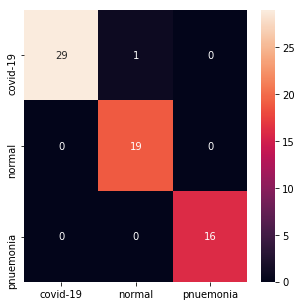

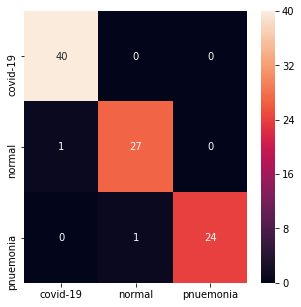

In [109]:
confusion_matrix_figure(val_result, test_result, num_classes, '121')

In [110]:
model_param = torch.load(best_model_path)
pytorch_total_params = sum(p.numel() for p in model_param.parameters())
pytorch_total_params

5280569

## cspdensenet169

In [85]:
path='/mnt/disks/user/project/results/multi/20210425205509/results.csv'
df = pd.read_csv(path)
df2 = df.sort_values(['val_accuracies', 'train_accuracies'], ascending=False)
df2 = df2[(df2['val_accuracies']!=100) & (df2['train_accuracies']!=100)]
df2.reset_index(drop=True, inplace=True)

In [86]:
df2.head()

,epoch,train_accuracies,val_accuracies,train_losses,val_losses,save_model_paths
0,49,99.740260,95.384615,0.022802,0.136289,/mnt/disks/user/project/weights/multi/20210425...
1,37,99.610390,95.384615,0.019463,0.107910,/mnt/disks/user/project/weights/multi/20210425...
2,64,99.025974,95.384615,0.043541,0.169512,/mnt/disks/user/project/weights/multi/20210425...
3,61,98.961039,95.384615,0.045531,0.150207,/mnt/disks/user/project/weights/multi/20210425...
4,39,98.766234,95.384615,0.037655,0.153868,/mnt/disks/user/project/weights/multi/20210425...


In [87]:
best_model_path = df2['save_model_paths'][0]
print(best_model_path)
val_result = covid_classification.testing(val_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
test_result = covid_classification.testing(test_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
print(val_result['report_df'], val_result['accuracy'])
print(test_result['report_df'], test_result['accuracy'])

/mnt/disks/user/project/weights/multi/20210425205509/49.pt
Accuracy of the network on the test images: 95 %
avg loss 0.13442806811071933
Accuracy of the network on the test images: 94 %
avg loss 0.1758096988002459
                   0          1          2  micro avg  macro avg  weighted avg
precision   1.000000   0.944444   0.888889   0.953846   0.944444      0.956410
recall      0.966667   0.894737   1.000000   0.953846   0.953801      0.953846
f1-score    0.983051   0.918919   0.941176   0.953846   0.947715      0.953997
support    30.000000  19.000000  16.000000  65.000000  65.000000     65.000000 95.38461538461539
                   0          1          2  micro avg  macro avg  weighted avg
precision   0.930233   0.961538   0.958333   0.946237   0.950035      0.947212
recall      1.000000   0.892857   0.920000   0.946237   0.937619      0.946237
f1-score    0.963855   0.925926   0.938776   0.946237   0.942852      0.945694
support    40.000000  28.000000  25.000000  93.000000  93

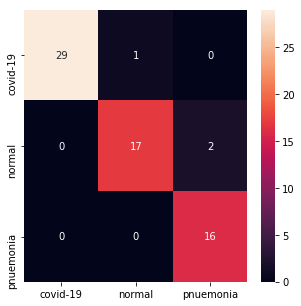

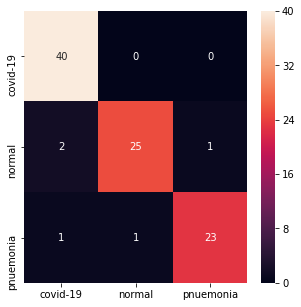

In [88]:
confusion_matrix_figure(val_result, test_result, num_classes, '169')

In [89]:
model_param = torch.load(best_model_path)
pytorch_total_params = sum(p.numel() for p in model_param.parameters())
pytorch_total_params

9761305

## cspdensenet201

In [90]:
path='/mnt/disks/user/project/results/multi/20210425234428/results.csv'
df = pd.read_csv(path)
df2 = df.sort_values(['val_accuracies', 'train_accuracies'], ascending=False)
df2 = df2[(df2['val_accuracies']!=100) & (df2['train_accuracies']!=100)]
df2.reset_index(drop=True, inplace=True)

In [91]:
df2.head()

,epoch,train_accuracies,val_accuracies,train_losses,val_losses,save_model_paths
0,13,98.116883,96.923077,0.072797,0.111340,/mnt/disks/user/project/weights/multi/20210425...
1,12,96.948052,96.923077,0.082265,0.131119,/mnt/disks/user/project/weights/multi/20210425...
2,99,95.714286,96.923077,0.130250,0.105858,/mnt/disks/user/project/weights/multi/20210425...
3,4,88.636364,96.923077,0.317266,0.092715,/mnt/disks/user/project/weights/multi/20210425...
4,38,99.415584,95.384615,0.025703,0.229206,/mnt/disks/user/project/weights/multi/20210425...


In [92]:
best_model_path = df2['save_model_paths'][0]
print(best_model_path)
val_result = covid_classification.testing(val_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
test_result = covid_classification.testing(test_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
print(val_result['report_df'], val_result['accuracy'])
print(test_result['report_df'], test_result['accuracy'])

/mnt/disks/user/project/weights/multi/20210425234428/13.pt
Accuracy of the network on the test images: 96 %
avg loss 0.10502039515413344
Accuracy of the network on the test images: 94 %
avg loss 0.16649262129794806
                   0          1     2  micro avg  macro avg  weighted avg
precision   1.000000   0.904762   1.0   0.969231   0.968254      0.972161
recall      0.933333   1.000000   1.0   0.969231   0.977778      0.969231
f1-score    0.965517   0.950000   1.0   0.969231   0.971839      0.969469
support    30.000000  19.000000  16.0  65.000000  65.000000     65.000000 96.92307692307692
                   0          1          2  micro avg  macro avg  weighted avg
precision   1.000000   0.875000   0.956522   0.946237   0.943841      0.950678
recall      0.950000   1.000000   0.880000   0.946237   0.943333      0.946237
f1-score    0.974359   0.933333   0.916667   0.946237   0.941453      0.946498
support    40.000000  28.000000  25.000000  93.000000  93.000000     93.000000 94

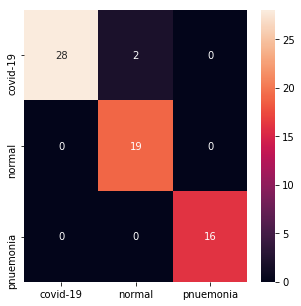

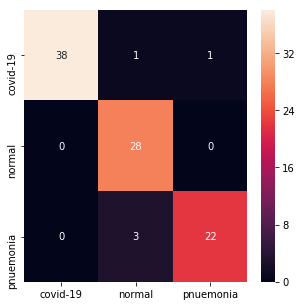

In [93]:
confusion_matrix_figure(val_result, test_result, num_classes, '201')

In [94]:
model_param = torch.load(best_model_path)
pytorch_total_params = sum(p.numel() for p in model_param.parameters())
pytorch_total_params

14202457

## cspdensenet264

In [95]:
path='/mnt/disks/user/project/results/multi/20210426065834/results.csv'
df = pd.read_csv(path)
df2 = df.sort_values(['val_accuracies', 'train_accuracies'], ascending=False)
df2 = df2[(df2['val_accuracies']!=100) & (df2['train_accuracies']!=100)]
df2.reset_index(drop=True, inplace=True)

In [96]:
df2.head()

,epoch,train_accuracies,val_accuracies,train_losses,val_losses,save_model_paths
0,38,99.480519,95.384615,0.023602,0.221512,/mnt/disks/user/project/weights/multi/20210426...
1,42,98.766234,95.384615,0.049802,0.174959,/mnt/disks/user/project/weights/multi/20210426...
2,20,98.376623,95.384615,0.042782,0.199109,/mnt/disks/user/project/weights/multi/20210426...
3,80,97.922078,95.384615,0.072951,0.092490,/mnt/disks/user/project/weights/multi/20210426...
4,90,97.532468,95.384615,0.080369,0.528883,/mnt/disks/user/project/weights/multi/20210426...


In [97]:
best_model_path = df2['save_model_paths'][0]
print(best_model_path)
val_result = covid_classification.testing(val_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
test_result = covid_classification.testing(test_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
print(val_result['report_df'], val_result['accuracy'])
print(test_result['report_df'], test_result['accuracy'])

/mnt/disks/user/project/weights/multi/20210426065834/38.pt
Accuracy of the network on the test images: 95 %
avg loss 0.2219675716944039
Accuracy of the network on the test images: 93 %
avg loss 0.16278470788771907
                   0          1          2  micro avg  macro avg  weighted avg
precision   1.000000   0.944444   0.888889   0.953846   0.944444      0.956410
recall      0.966667   0.894737   1.000000   0.953846   0.953801      0.953846
f1-score    0.983051   0.918919   0.941176   0.953846   0.947715      0.953997
support    30.000000  19.000000  16.000000  65.000000  65.000000     65.000000 95.38461538461539
                   0          1          2  micro avg  macro avg  weighted avg
precision   0.930233   1.000000   0.884615   0.935484   0.938283      0.938975
recall      1.000000   0.857143   0.920000   0.935484   0.925714      0.935484
f1-score    0.963855   0.923077   0.901961   0.935484   0.929631      0.934940
support    40.000000  28.000000  25.000000  93.000000  93

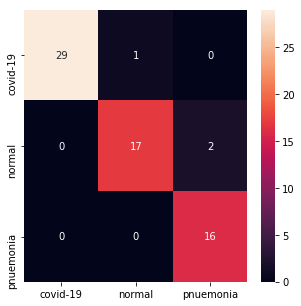

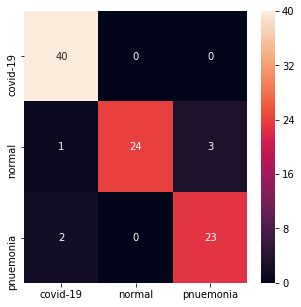

In [98]:
confusion_matrix_figure(val_result, test_result, num_classes, '264')

In [99]:
model_param = torch.load(best_model_path)
pytorch_total_params = sum(p.numel() for p in model_param.parameters())
pytorch_total_params

28548573

In [114]:
#121
model_param = torch.load(best_model_path)
pytorch_total_params = sum(p.numel() for p in model_param.parameters())
pytorch_total_params

5280569

In [115]:
covid_identified_as_other, incorrectly_identified_as_covid = grid_images(test_result, typ='incorrect_identified')
covid_identified_as_other, incorrectly_identified_as_covid

({},
 {'/mnt/disks/user/project/dataset/multi/test/Normal/Normal_064.jpeg': (1, 0),
  '/mnt/disks/user/project/dataset/multi/test/Viral Pneumonia/Viral Pneumonia_013.jpeg': (2,
   1)})

In [116]:
img_to_draw = list(covid_identified_as_other.keys())[:2]
if img_to_draw:
    show(image_to_tensor(img_to_draw), 'covid_identified_as_other x-ray images', figsize=(5,5))

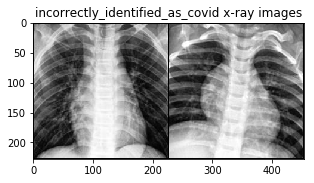

In [117]:
img_to_draw = list(incorrectly_identified_as_covid.keys())[:2]
if img_to_draw:
    show(image_to_tensor(img_to_draw), 'incorrectly_identified_as_covid x-ray images', figsize=(5,5))

In [118]:
covid_identified_as_other, incorrectly_identified_as_covid = grid_images(test_result, typ='correct_identified')
covid_identified_as_other, incorrectly_identified_as_covid

({'/mnt/disks/user/project/dataset/multi/test/Covid/Covid_07.jpeg': (0, 0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_090.jpeg': (0, 0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_054.jpeg': (0, 0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_046.jpeg': (0, 0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_COVID-00018.jpeg': (0,
   0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg': (0,
   0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_COVID-00003b.jpeg': (0,
   0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_061.jpeg': (0, 0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_051.jpeg': (0, 0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_0112.jpeg': (0, 0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_COVID-00022.jpeg': (0,
   0),
  '/mnt/disks/user/project/dataset/multi/test/Covid/Co

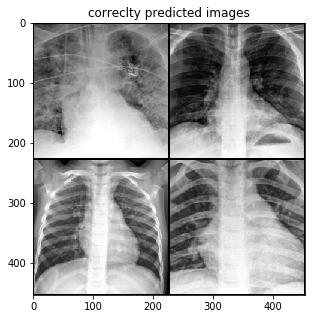

In [119]:
img_to_draw = list(covid_identified_as_other.keys())[:2] + list(incorrectly_identified_as_covid.keys())[:2]
if img_to_draw:
    show(image_to_tensor(img_to_draw), 'correclty predicted images', figsize=(5,5))

In [120]:
img_to_draw

['/mnt/disks/user/project/dataset/multi/test/Covid/Covid_07.jpeg',
 '/mnt/disks/user/project/dataset/multi/test/Covid/Covid_090.jpeg',
 '/mnt/disks/user/project/dataset/multi/test/Normal/Normal_079.jpeg',
 '/mnt/disks/user/project/dataset/multi/test/Viral Pneumonia/Viral Pneumonia_047.jpeg']

## confusion matrix


In [177]:
m1 = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp121_44.pt'
m2 = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp169_49.pt'
m3 = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp201_13.pt'
m4 = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp264_38.pt'


In [178]:
import seaborn as sn
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
# make the color map:

def confusion_matrix_figure2(val_result, test_result, num_classes, model):
    cmp = ListedColormap(['white', '#87CEFF'])
    if num_classes==3:
        sub = 'multi'
        cols = ['Covid-19', 'Normal', 'Viral Pnuemonia']
    elif num_classes==2:
        sub = 'binary'
        cols = ['Covid-19', 'Non-covid']
    fig = plt.figure(figsize=(5,5))
    val_df = pd.DataFrame(val_result['confusion_matrix'], columns=cols, index=cols)
    val_df.columns.name='Predicted Values'
    val_df.index.name='Actual Values'
    plt.xlabel('Predicted')
    plt.xlabel('Actual')
    sn.heatmap(val_df, annot=True, cbar=False, cmap=cmp, vmin=3, vmax=15, linewidths=1, linecolor='#000000')
    plt.show()
    
#     plt.yticks(rotation=0) 
    fig.savefig('figures/'+sub+'/'+model+'_val.png', format='png', dpi=300)
    fig = plt.figure(figsize=(5,5))
    test_df = pd.DataFrame(test_result['confusion_matrix'], columns=cols, index=cols)
    test_df.columns.name='Predicted Values'
    test_df.index.name='Actual Values'
    plt.xlabel('Predicted Values')
    plt.xlabel('Actual Values')
    sn.heatmap(test_df, annot=True, cbar=False, cmap=cmp, vmin=3, vmax=15, linewidths=1, linecolor='#000000')
    plt.show()
#     plt.yticks(rotation=0) 
    fig.savefig('figures/'+sub+'/'+model+'_test'+'.png', format='png', dpi=300)

G:\softwarelife\LJMU\thesis\code\weights\multi_csp121_44.pt
Accuracy of the network on the test images: 98 %
avg loss 0.07057944694533944
Accuracy of the network on the test images: 97 %
avg loss 0.06718014211704333
                   0          1     2  accuracy  macro avg  weighted avg
precision   1.000000   0.950000   1.0  0.984615   0.983333      0.985385
recall      0.966667   1.000000   1.0  0.984615   0.988889      0.984615
f1-score    0.983051   0.974359   1.0  0.984615   0.985803      0.984682
support    30.000000  19.000000  16.0  0.984615  65.000000     65.000000 98.46153846153847
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.975610   0.964286   1.000000  0.978495   0.979965      0.978757
recall      1.000000   0.964286   0.960000  0.978495   0.974762      0.978495
f1-score    0.987654   0.964286   0.979592  0.978495   0.977177      0.978451
support    40.000000  28.000000  25.000000  0.978495  93.000000     93.000000 97.84946236

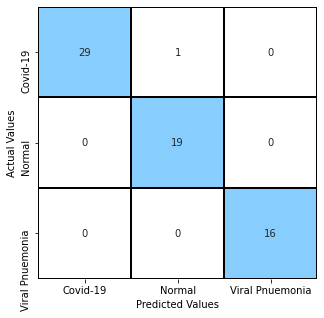

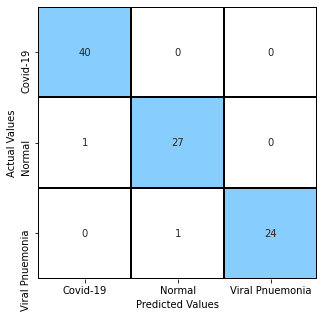

G:\softwarelife\LJMU\thesis\code\weights\multi_csp169_49.pt
Accuracy of the network on the test images: 95 %
avg loss 0.13467177494894714
Accuracy of the network on the test images: 94 %
avg loss 0.18227732460945845
                   0          1          2  accuracy  macro avg  weighted avg
precision   1.000000   0.944444   0.888889  0.953846   0.944444      0.956410
recall      0.966667   0.894737   1.000000  0.953846   0.953801      0.953846
f1-score    0.983051   0.918919   0.941176  0.953846   0.947715      0.953997
support    30.000000  19.000000  16.000000  0.953846  65.000000     65.000000 95.38461538461539
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.930233   0.961538   0.958333  0.946237   0.950035      0.947212
recall      1.000000   0.892857   0.920000  0.946237   0.937619      0.946237
f1-score    0.963855   0.925926   0.938776  0.946237   0.942852      0.945694
support    40.000000  28.000000  25.000000  0.946237  93.000000 

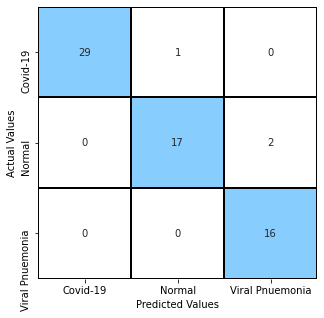

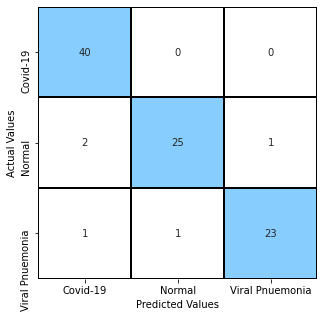

G:\softwarelife\LJMU\thesis\code\weights\multi_csp201_13.pt
Accuracy of the network on the test images: 96 %
avg loss 0.10583060225471855
Accuracy of the network on the test images: 94 %
avg loss 0.1651627328246832
                   0          1     2  accuracy  macro avg  weighted avg
precision   1.000000   0.904762   1.0  0.969231   0.968254      0.972161
recall      0.933333   1.000000   1.0  0.969231   0.977778      0.969231
f1-score    0.965517   0.950000   1.0  0.969231   0.971839      0.969469
support    30.000000  19.000000  16.0  0.969231  65.000000     65.000000 96.92307692307692
                   0          1          2  accuracy  macro avg  weighted avg
precision   1.000000   0.875000   0.956522  0.946237   0.943841      0.950678
recall      0.950000   1.000000   0.880000  0.946237   0.943333      0.946237
f1-score    0.974359   0.933333   0.916667  0.946237   0.941453      0.946498
support    40.000000  28.000000  25.000000  0.946237  93.000000     93.000000 94.623655913

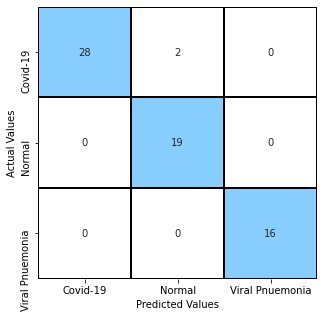

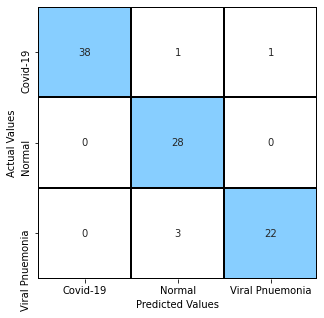

G:\softwarelife\LJMU\thesis\code\weights\multi_csp264_38.pt
Accuracy of the network on the test images: 95 %
avg loss 0.22093722132849508
Accuracy of the network on the test images: 93 %
avg loss 0.16936792402217785
                   0          1          2  accuracy  macro avg  weighted avg
precision   1.000000   0.944444   0.888889  0.953846   0.944444      0.956410
recall      0.966667   0.894737   1.000000  0.953846   0.953801      0.953846
f1-score    0.983051   0.918919   0.941176  0.953846   0.947715      0.953997
support    30.000000  19.000000  16.000000  0.953846  65.000000     65.000000 95.38461538461539
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.930233   1.000000   0.884615  0.935484   0.938283      0.938975
recall      1.000000   0.857143   0.920000  0.935484   0.925714      0.935484
f1-score    0.963855   0.923077   0.901961  0.935484   0.929631      0.934940
support    40.000000  28.000000  25.000000  0.935484  93.000000 

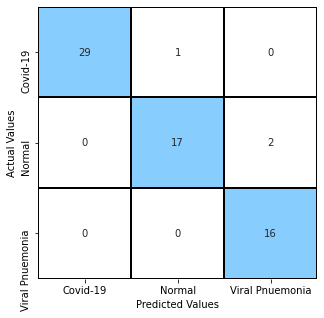

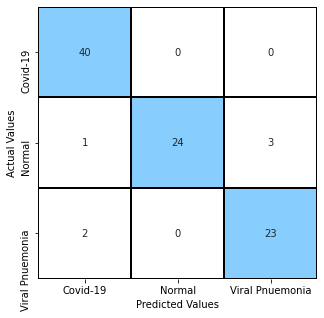

In [180]:
for best_model_path in [m1, m2, m3, m4]:
    print(best_model_path)
    val_result = covid_classification.testing(val_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
    test_result = covid_classification.testing(test_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
    print(val_result['report_df'], val_result['accuracy'])
    print(test_result['report_df'], test_result['accuracy'])
    model = best_model_path.split('\\')[-1].split('.')[0]
    confusion_matrix_figure2(val_result, test_result, num_classes, model)

In [25]:
best_model_path = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp121_44.pt'
# best_model_path = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp169_49.pt'
# best_model_path = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp201_13.pt'
# best_model_path = r'G:\softwarelife\LJMU\thesis\code\weights\multi_csp264_38.pt'


In [26]:
print(best_model_path)
val_result = covid_classification.testing(val_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
test_result = covid_classification.testing(test_dataset_path, batch_size, best_model_path, device, criterion, num_classes)
print(val_result['report_df'], val_result['accuracy'])
print(test_result['report_df'], test_result['accuracy'])

G:\softwarelife\LJMU\thesis\code\weights\multi_csp121_44.pt
Accuracy of the network on the test images: 98 %
avg loss 0.07057944694533944
Accuracy of the network on the test images: 97 %
avg loss 0.06718014211704333
                   0          1     2  accuracy  macro avg  weighted avg
precision   1.000000   0.950000   1.0  0.984615   0.983333      0.985385
recall      0.966667   1.000000   1.0  0.984615   0.988889      0.984615
f1-score    0.983051   0.974359   1.0  0.984615   0.985803      0.984682
support    30.000000  19.000000  16.0  0.984615  65.000000     65.000000 98.46153846153847
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.975610   0.964286   1.000000  0.978495   0.979965      0.978757
recall      1.000000   0.964286   0.960000  0.978495   0.974762      0.978495
f1-score    0.987654   0.964286   0.979592  0.978495   0.977177      0.978451
support    40.000000  28.000000  25.000000  0.978495  93.000000     93.000000 97.84946236

In [27]:
out_df = pd.DataFrame(columns=[0,1,2])
for data_ in test_result['outputs_']:
    dff = pd.DataFrame(data_.data.cpu().detach().numpy(), columns=[0,1,2])
    out_df = pd.concat([out_df, dff])
out_df=out_df/3

In [28]:
act_df = pd.DataFrame({'res_del':test_result['report_actual']})
act_df[0] = act_df['res_del'].apply(lambda x:1 if x==0 else 0)
act_df[1] = act_df['res_del'].apply(lambda x:1 if x==1 else 0)
act_df[2] = act_df['res_del'].apply(lambda x:1 if x==2 else 0)
del act_df['res_del']

In [29]:
n_classes = 3
y_test = act_df.to_numpy()
y_score = out_df.to_numpy()

In [30]:
from sklearn.metrics import roc_curve, auc

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [31]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [32]:
from scipy import interp
from itertools import cycle
lw = 2

C:\Users\veere\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


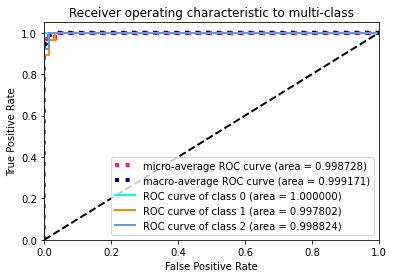

In [34]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig=plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
fig.savefig("eda_images\\ROC CURVE - Multi Classification.png", format='png',dpi=300)